In [2]:
import pandas
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

In [1]:
data = pandas.read_excel("voitures_clustering.ipynb")
data

NameError: name 'pandas' is not defined

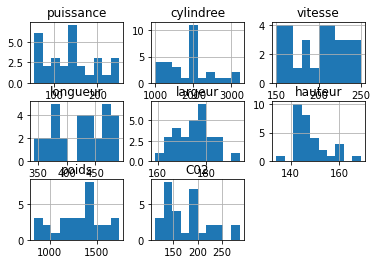

In [3]:
data.hist(bins=10);

In [4]:
data_scaled = preprocessing.scale(data.iloc[:, 1:])  # standardisation

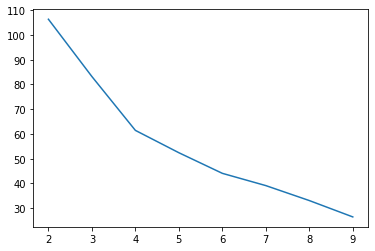

In [11]:
X, Y = [], []
for i in range(2, 10):
    km = KMeans(n_clusters=i).fit(data_scaled)
    Y.append(km.inertia_)
    X.append(i)
plt.plot(X, Y)
plt.show()

In [14]:
km = KMeans(n_clusters=4).fit(data_scaled)

In [18]:
dt = data.iloc[:, 1:]

for i in range(km.n_clusters):
    t = np.where(km.labels_ == i)[0]
    y = np.zeros((len(data.index)))
    y[t] = 1
    lr = LogisticRegression(max_iter = 4000).fit(dt, y)
    pd = pandas.DataFrame(np.array([np.mean(data.loc[t]), lr.coef_[0]]).T, index = dt.columns, columns = ["Moyenne", "Coeffs"])
    print(pd)

               Moyenne    Coeffs
puissance    68.285714 -0.071782
cylindree  1212.428571 -0.018595
vitesse     161.142857  0.052172
longueur    369.571429  0.188986
largeur     164.428571  0.079396
hauteur     146.285714  0.041197
poids       952.142857 -0.038762
C02         130.000000 -0.186173
               Moyenne    Coeffs
puissance   145.090909 -0.435008
cylindree  1950.454545 -0.019804
vitesse     210.909091  0.710963
longueur    454.363636  0.262498
largeur     180.000000 -0.482883
hauteur     145.727273 -0.859915
poids      1411.545455  0.045929
C02         180.818182 -0.074443
           Moyenne    Coeffs
puissance    100.6 -0.368794
cylindree   1765.4  0.023960
vitesse      179.2 -0.007900
longueur     391.6 -0.514661
largeur      172.4  0.203545
hauteur      159.6  0.417526
poids       1236.6  0.073590
C02          149.2  0.099268
               Moyenne    Coeffs
puissance   221.857143  0.183798
cylindree  2619.142857  0.019029
vitesse     234.000000 -0.084655
longueur    4

/home/qfortier/.cache/pypoetry/virtualenvs/notebook-Otwu4MGz-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3370: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/qfortier/.cache/pypoetry/virtualenvs/notebook-Otwu4MGz-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3370: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/qfortier/.cache/pypoetry/virtualenvs/notebook-Otwu4MGz-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3370: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'nu